(15, 15)


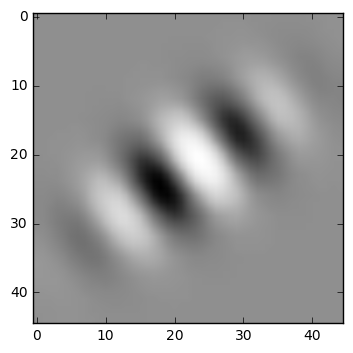

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn

def getRandomGaborParams(size):
    
    theta = np.pi*(2*rand() - 1)
    psi = np.pi*rand()
    sigma = 3*np.abs(randn()) + 10e-3
    lambd = 5*np.abs(randn()) + 10e-3
    gamma = np.pi*rand()
    return {'ksize':size, 'sigma':sigma, 'theta': theta, 'lambd':lambd, 'gamma':gamma, 'psi': psi}
    

# cv2.getGaborKernel(ksize, sigma, theta, lambda, gamma, psi, ktype)
# ksize - size of gabor filter (n, n)
# sigma - standard deviation of the gaussian function
# theta - orientation of the normal to the parallel stripes
# lambda - wavelength of the sunusoidal factor
# gamma - spatial aspect ratio
# psi - phase offset
# ktype - type and range of values that each pixel in the gabor kernel can hold

params = getRandomGaborParams((15,15))
g_kernel = cv2.getGaborKernel(**params)
print(g_kernel.shape)

img = cv2.imread('cat.jpg',0)
filtered_img = cv2.filter2D(img, cv2.CV_32F, g_kernel)

h, w = g_kernel.shape[:2]
g_show = cv2.resize(g_kernel, (3*w, 3*h), interpolation=cv2.INTER_CUBIC)
plt.imshow(g_show, cmap='Greys')
plt.show()

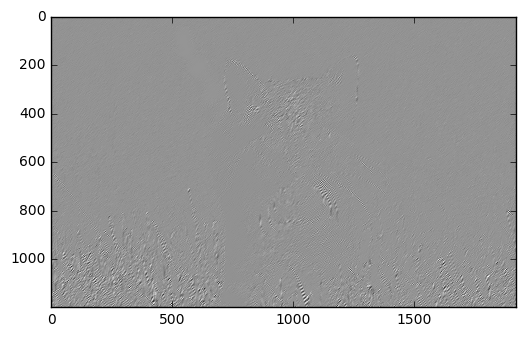

In [4]:
plt.imshow(filtered_img, cmap='Greys')
plt.show()

## My Gabor filter implementation

 Parameters
    ----------
    frequency : float
        Spatial frequency of the harmonic function. Specified in pixels.
    theta : float, optional
        Orientation in radians. If 0, the harmonic is in the x-direction.
    bandwidth : float, optional
        The bandwidth captured by the filter. For fixed bandwidth, `sigma_x`
        and `sigma_y` will decrease with increasing frequency. This value is
        ignored if `sigma_x` and `sigma_y` are set by the user.
    sigma_x, sigma_y : float, optional
        Standard deviation in x- and y-directions. These directions apply to
        the kernel *before* rotation. If `theta = pi/2`, then the kernel is
        rotated 90 degrees so that `sigma_x` controls the *vertical* direction.
    n_stds : scalar, optional
        The linear size of the kernel is n_stds (3 by default) standard
        deviations
    offset : float, optional
        Phase offset of harmonic function in radians.

In [165]:
def myGaborKernel(size = 9, frequency = 1, theta=0, sigma_x=5, sigma_y=5, psi=0):

    x0 = np.ceil(max(size/2, 1))
    y0 = np.ceil(max(size/2, 1))
    y, x = np.mgrid[-y0+1:y0, -x0+1:x0]/size

    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)

    g = np.zeros(y.shape, dtype=np.complex)
    g[:] = np.exp(-0.5 * (rotx ** 2 / sigma_x ** 2 + roty ** 2 / sigma_y ** 2))
    #g /= 2 * np.pi * sigma_x * sigma_y
    g *= np.exp(1j * (2 * np.pi * frequency * rotx + psi))
    
    return g

In [185]:
def myGaborKernelCurve(size = 9, frequency = 1, theta=0, sigma_x=5, sigma_y=5, psi=0, cx = 0, cy = 0, r0 = 1):
    r0 = r0
    cx = 0
    cy = 0
    x0 = np.ceil(max(size/2, 1))
    y0 = np.ceil(max(size/2, 1))
    print(x0,y0)
    y, x = np.mgrid[-y0+1:y0, -x0+1:x0]/size
    print(x)
    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)
    curvex = cx - r0*np.cos(theta)
    curvey = cy - r0*np.sin(theta)
    
    r = np.sqrt( (x - curvex)**2 + (y - curvey)**2)

    g = np.zeros(y.shape, dtype=np.complex)
    g[:] = np.exp(-0.5 * (rotx ** 2 / sigma_x ** 2 + roty ** 2 / sigma_y ** 2))
    #g /= 2 * np.pi * sigma_x * sigma_y
    g *= np.exp(1j * (2 * np.pi * frequency * r + psi))
    
    return g.T

10.0 10.0
[[-0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1
   0.15  0.2   0.25  0.3   0.35  0.4   0.45]
 [-0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1
   0.15  0.2   0.25  0.3   0.35  0.4   0.45]
 [-0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1
   0.15  0.2   0.25  0.3   0.35  0.4   0.45]
 [-0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1
   0.15  0.2   0.25  0.3   0.35  0.4   0.45]
 [-0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1
   0.15  0.2   0.25  0.3   0.35  0.4   0.45]
 [-0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1
   0.15  0.2   0.25  0.3   0.35  0.4   0.45]
 [-0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1
   0.15  0.2   0.25  0.3   0.35  0.4   0.45]
 [-0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1
   0.15  0.2   0.25  0.3   0.35  0.4   0.45]
 [-0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0

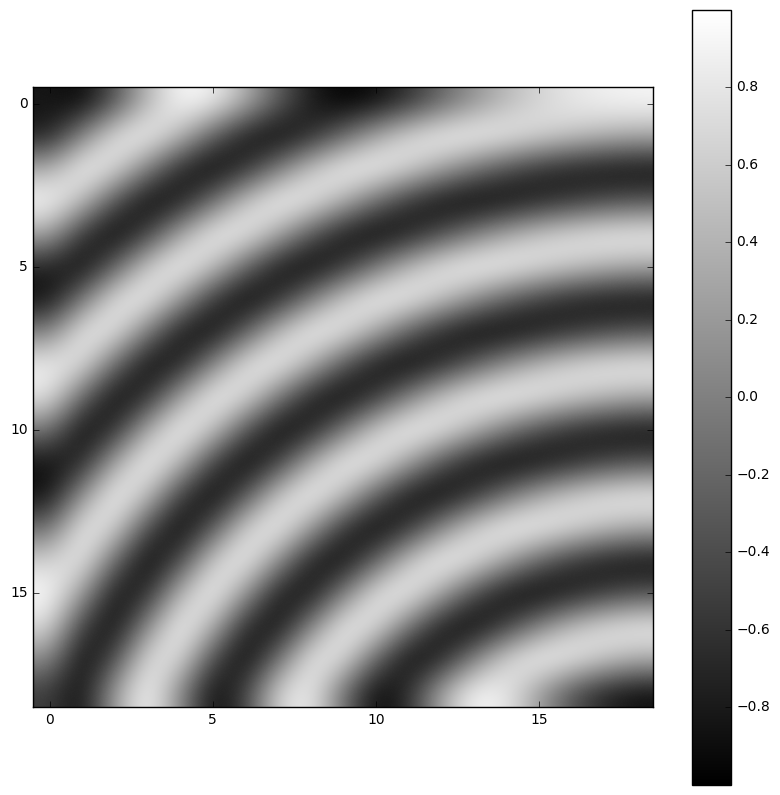

In [186]:
gkm = myGaborKernelCurve(frequency=5, sigma_x = 20, sigma_y = 20, theta=np.pi + np.pi/6, size = 20, psi=3, r0 = 1)
plt.figure(figsize = (10,10))        # doctest: +SKIP
plt.imshow(gkm.real, interpolation='bicubic', cmap = 'gray')
plt.colorbar()# doctest: +SKIP
plt.show()

In [151]:

>>> from skimage.filters import gabor_kernel
>>> from skimage import io
>>> from matplotlib import pyplot as plt  # doctest: +SKIP
          # doctest: +SKIP

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


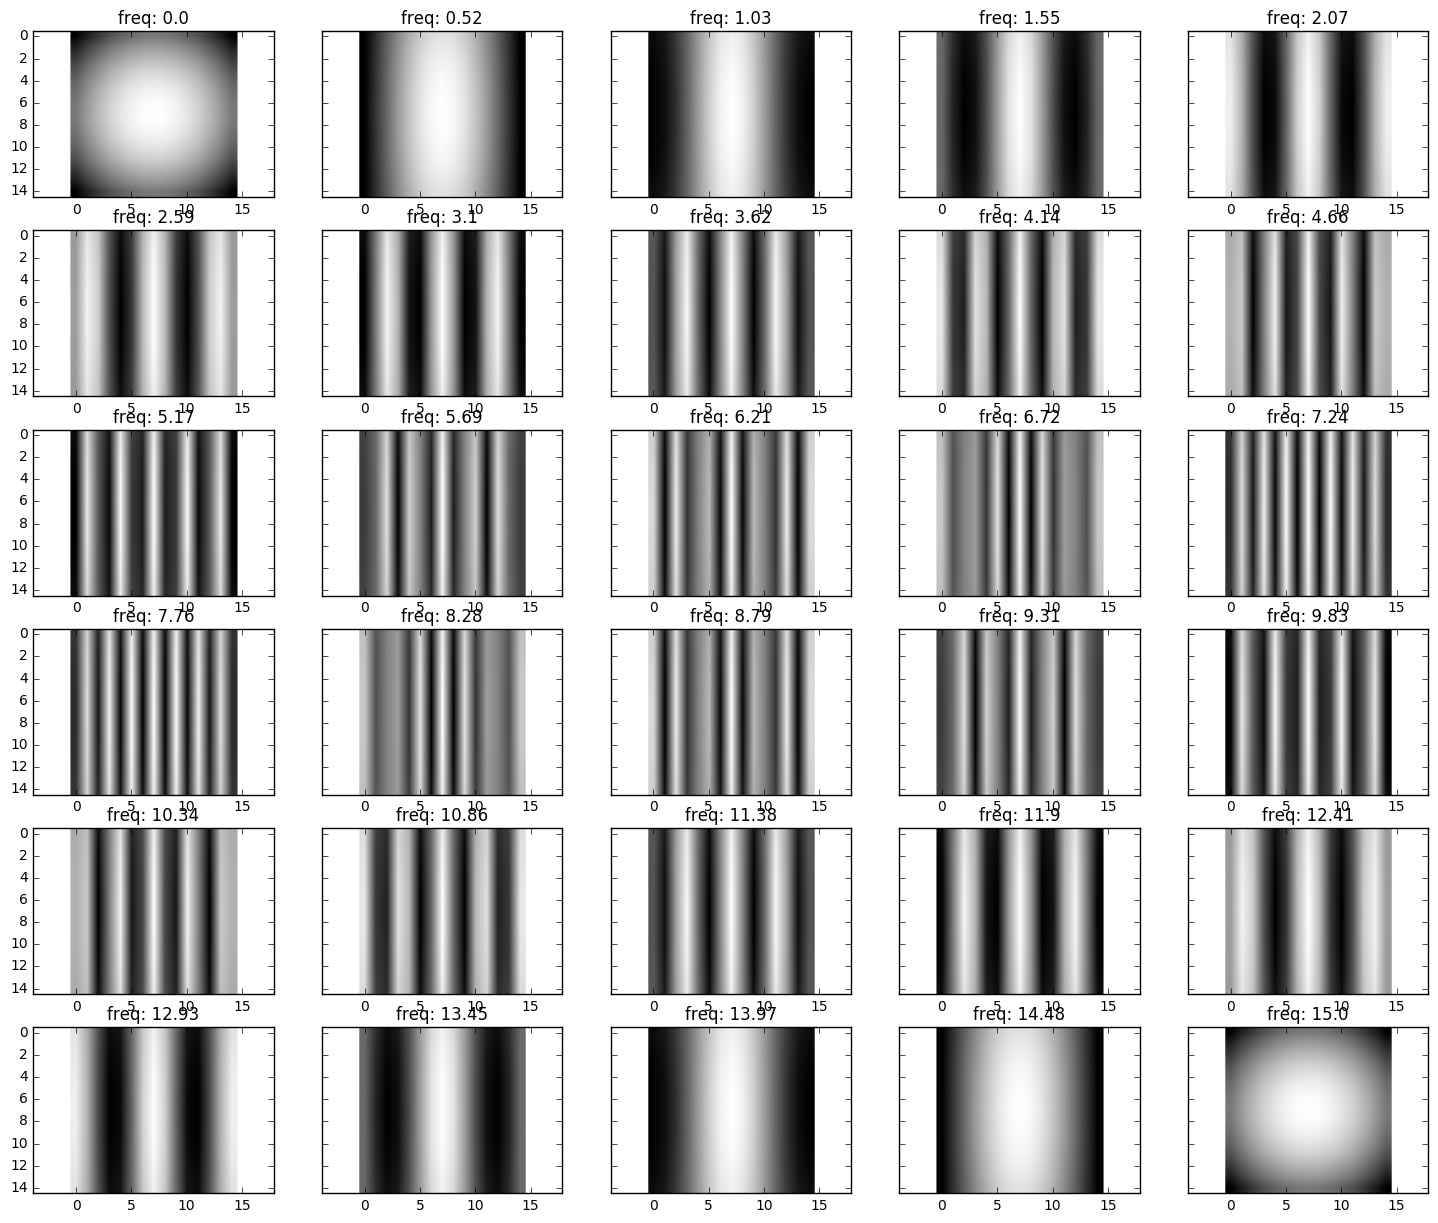

In [175]:
fig, axs = plt.subplots(6, 5, figsize=(18, 15), sharey=True)
row = 0
col = 0
for i in np.linspace(0.,15,30):
    gkm = myGaborKernel(frequency=i, sigma_x = 1, sigma_y = 1, theta=0, size = 15, psi=0)
    plt.figure(figsize = (3,3))        # doctest: +SKIP
    axs[row, col].imshow(gkm.real, cmap = 'gray')
    axs[row, col].set_title('freq: '+ str(np.round(i,2)))
    col += 1
    if col > 4:
        col = 0
        row += 1
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


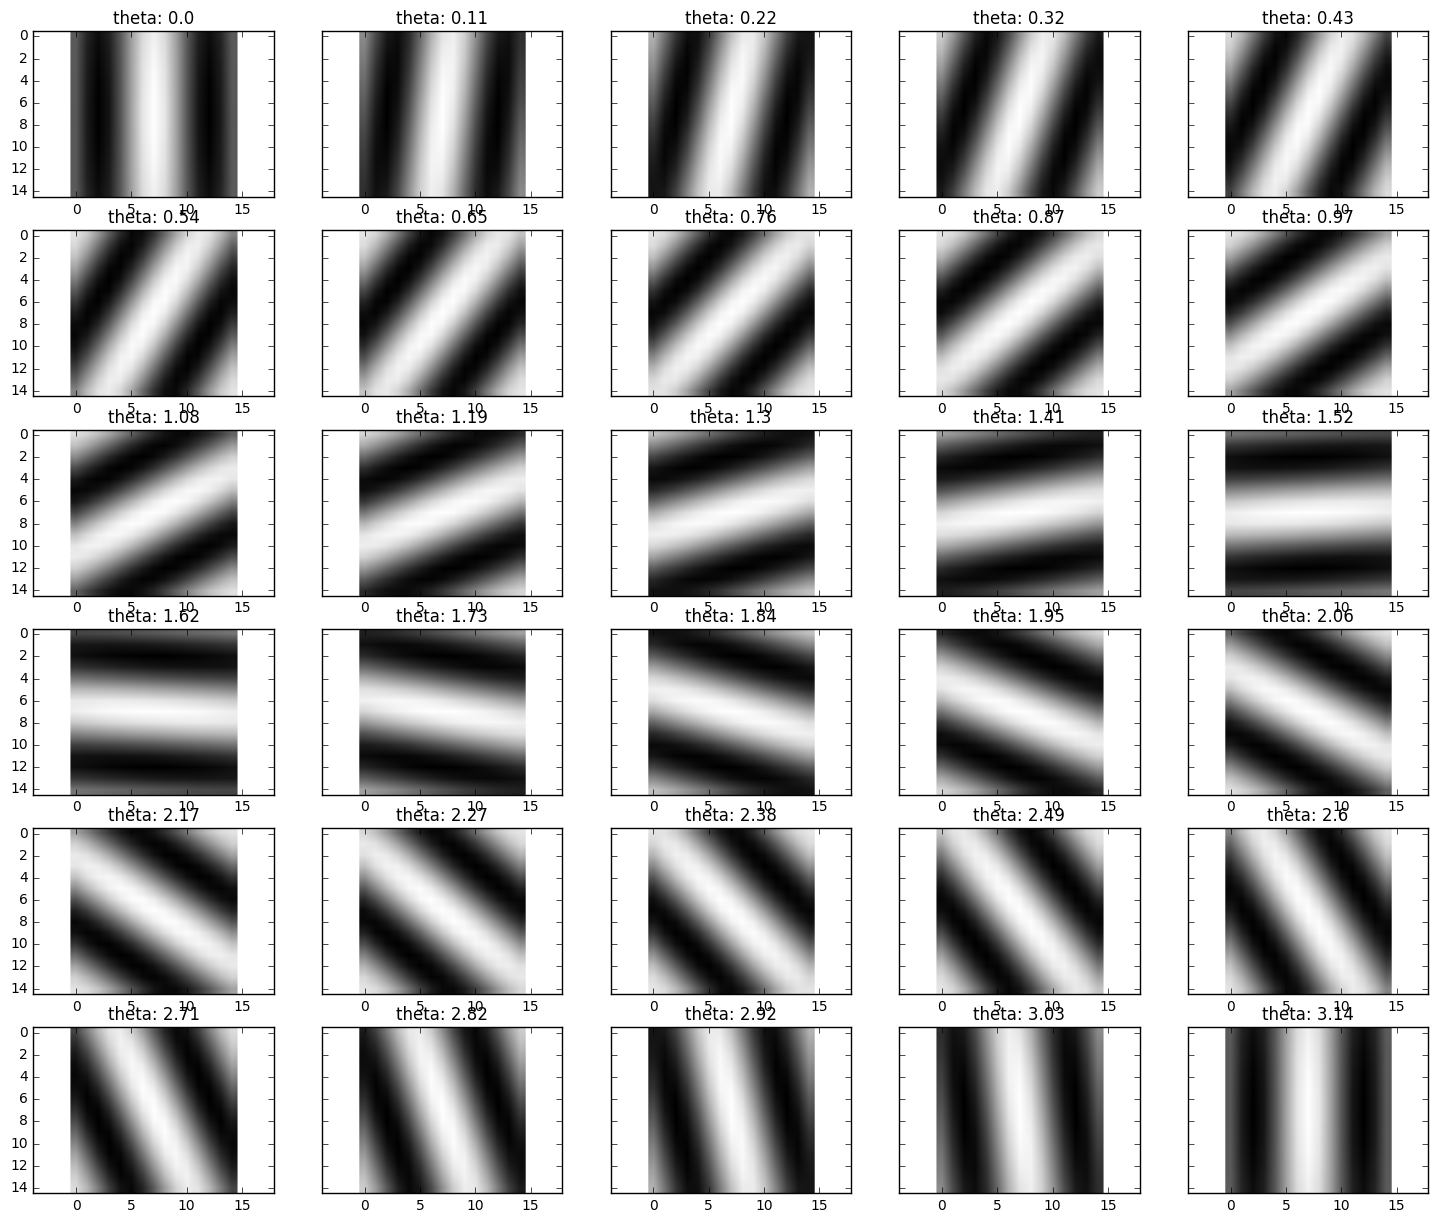

In [177]:
fig, axs = plt.subplots(6, 5, figsize=(18, 15), sharey=True)
row = 0
col = 0
for i in np.linspace(0.,3.14,30):
    gkm = myGaborKernel(frequency=1.5, sigma_x = 1, sigma_y = 1, theta=i, size = 15, psi=0)
    plt.figure(figsize = (3,3))        # doctest: +SKIP
    axs[row, col].imshow(gkm.real, cmap = 'gray')
    axs[row, col].set_title('theta: '+ str(np.round(i,2)))
    col += 1
    if col > 4:
        col = 0
        row += 1
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


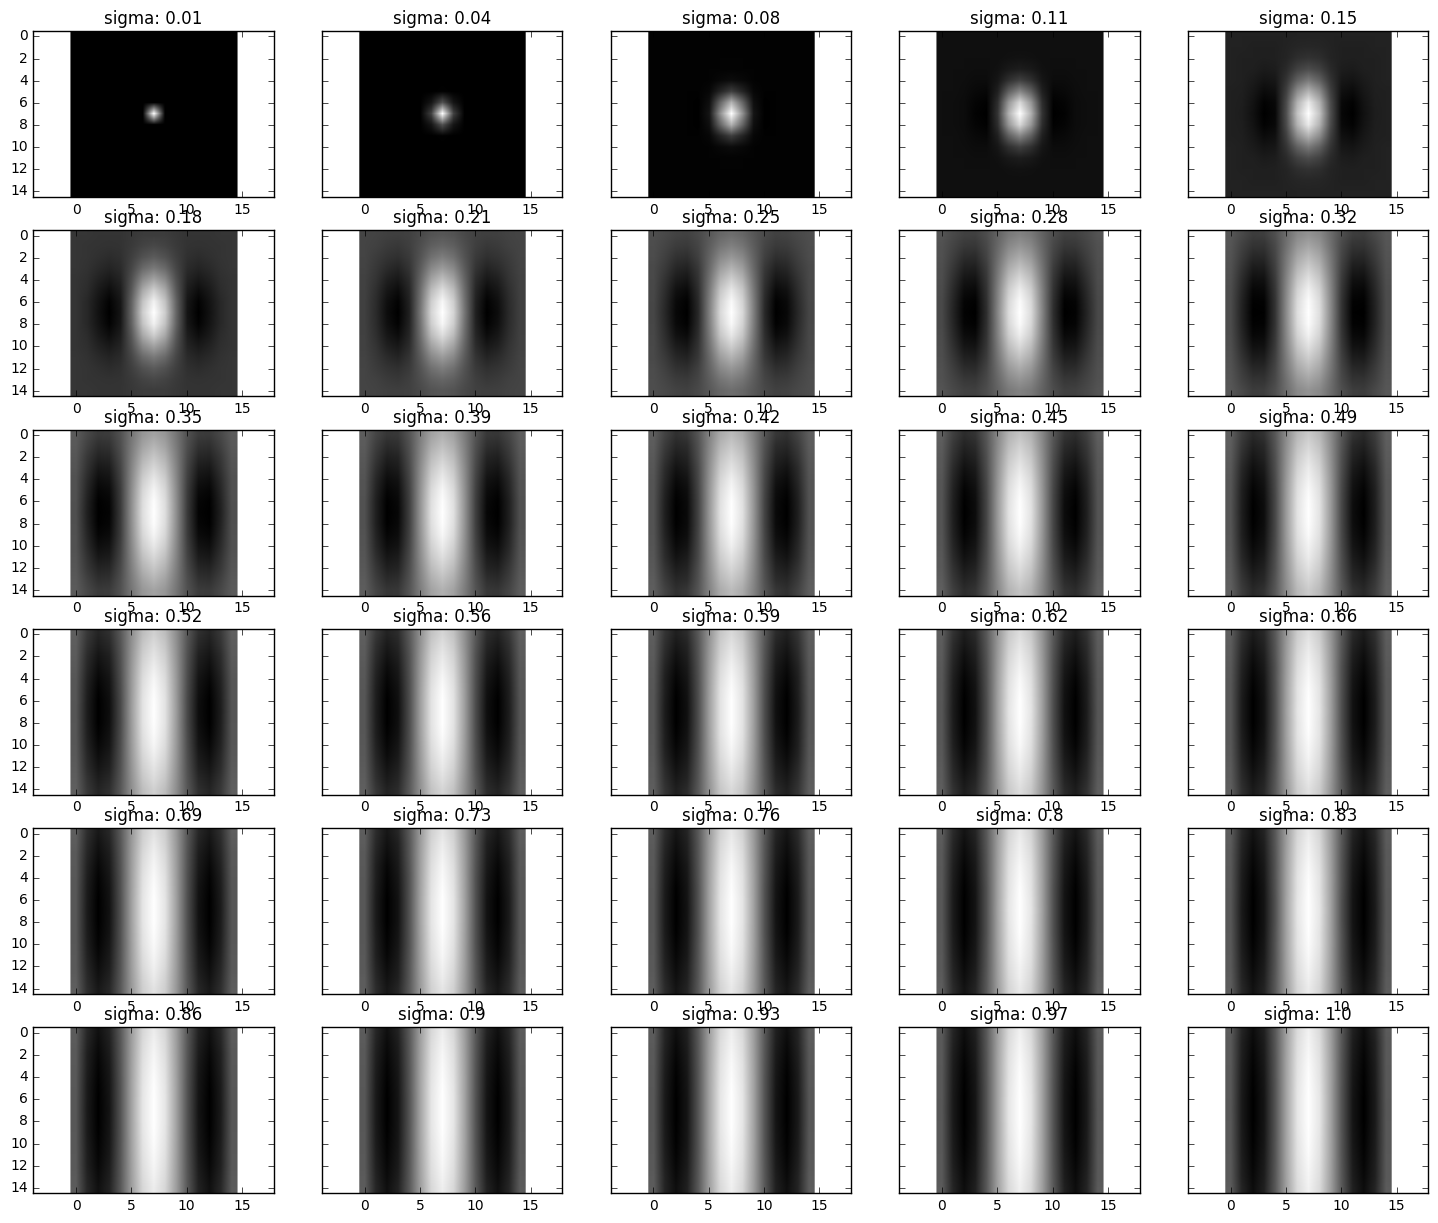

In [178]:
fig, axs = plt.subplots(6, 5, figsize=(18, 15), sharey=True)
row = 0
col = 0
for i in np.linspace(0.01,1,30):
    gkm = myGaborKernel(frequency=1.5, sigma_x = i, sigma_y = i, theta=0, size = 15, psi=0)
    plt.figure(figsize = (3,3))        # doctest: +SKIP
    axs[row, col].imshow(gkm.real, cmap = 'gray')
    axs[row, col].set_title('sigma: '+ str(np.round(i,2)))
    col += 1
    if col > 4:
        col = 0
        row += 1
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


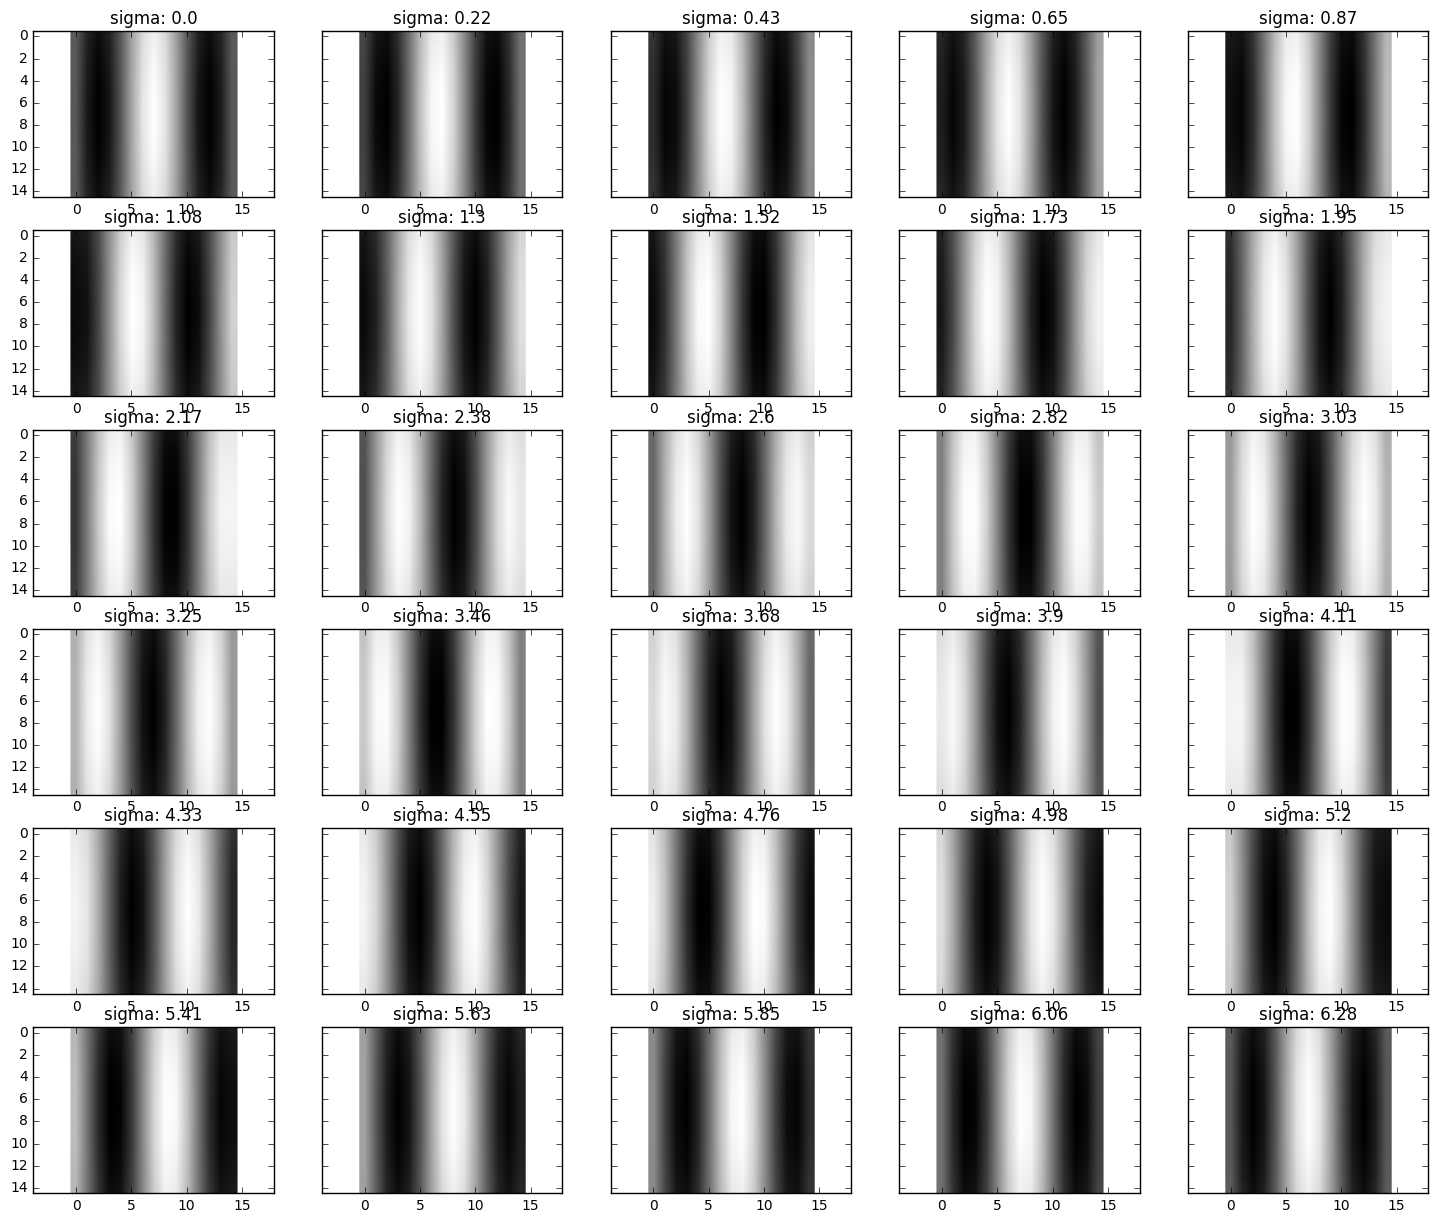

In [173]:
fig, axs = plt.subplots(6, 5, figsize=(18, 15), sharey=True)
row = 0
col = 0
for i in np.linspace(0.0,6.28,30):
    gkm = myGaborKernel(frequency=1.5, sigma_x = 1, sigma_y = 1, theta=0, size = 15, psi=i)
    plt.figure(figsize = (3,3))        # doctest: +SKIP
    axs[row, col].imshow(gkm.real, cmap = 'gray')
    axs[row, col].set_title('sigma: '+ str(np.round(i,2)))
    col += 1
    if col > 4:
        col = 0
        row += 1
plt.show()

10.0 10.0


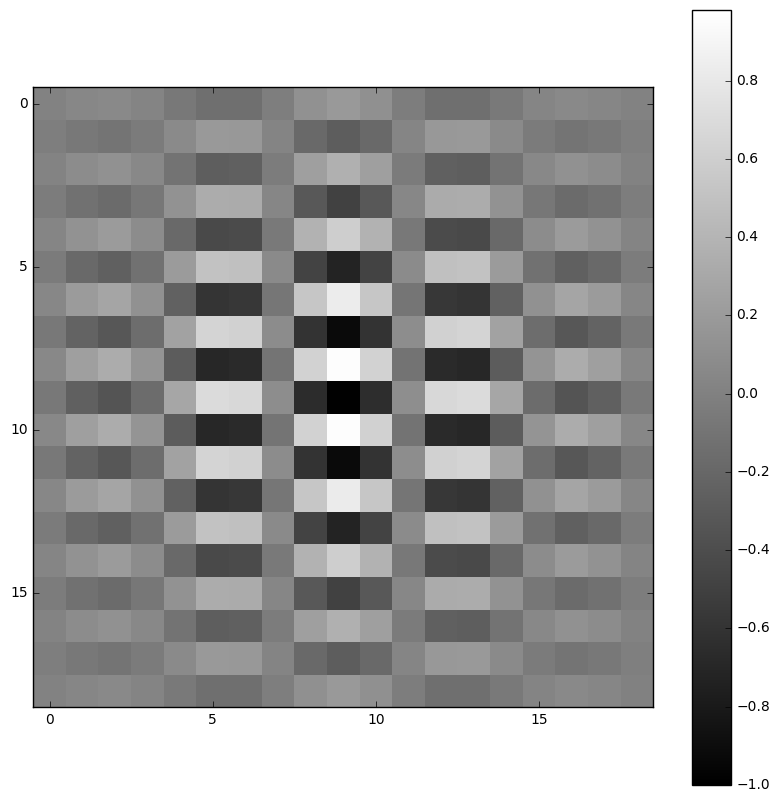

In [96]:
gkm = myGaborKernel(frequency=20, sigma_x = 5/20, sigma_y = 5/20, theta=np.pi/6, size = 20, psi=np.pi)
plt.figure(figsize = (10,10))        # doctest: +SKIP
plt.imshow(gkm.real, interpolation='none', cmap = 'gray')
plt.colorbar()# doctest: +SKIP
plt.show()

## Рисунок 1: Габор без деления на size. Рис.2 Габор с делением на size. Видно что при делении на size изменяется машстаб пармаетров. Freq следует увеличить в size-раз, а sigma (x и y) уменишить в size раз для получения аналогичного результата. ==> Изменение масштаба не критично. Но следует аккуратно обращаться с параметрами.

100.0 100.0


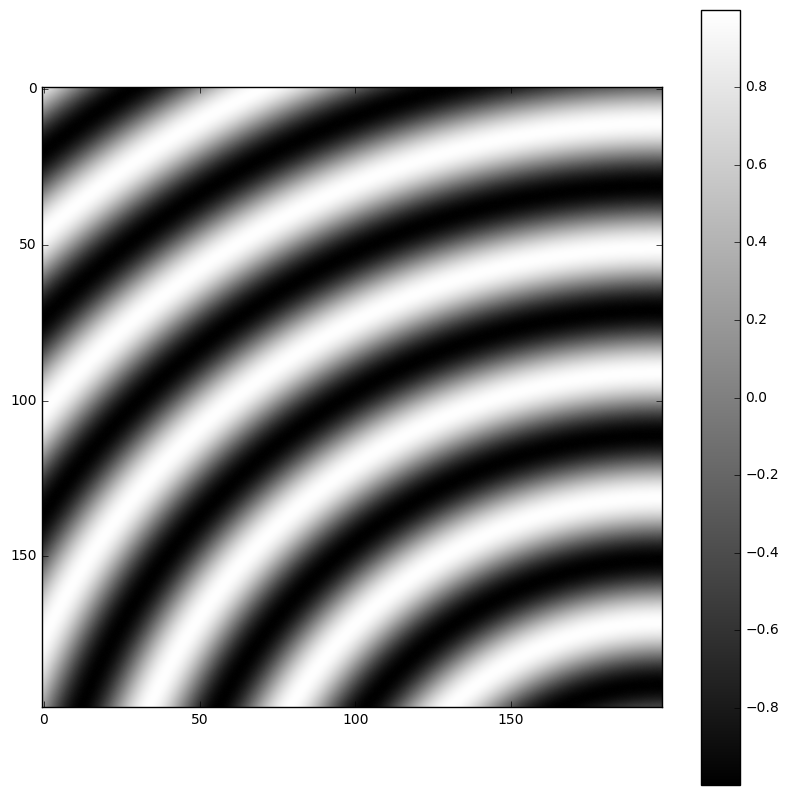

In [183]:
gkm = myGaborKernelCurve(frequency=5, sigma_x = 20, sigma_y = 20, theta=np.pi + np.pi/6, size = 200, psi=3, r0 = 1)
plt.figure(figsize = (10,10))        # doctest: +SKIP
plt.imshow(gkm.real, interpolation='bicubic', cmap = 'gray')
plt.colorbar()# doctest: +SKIP
plt.show()

100.0 100.0


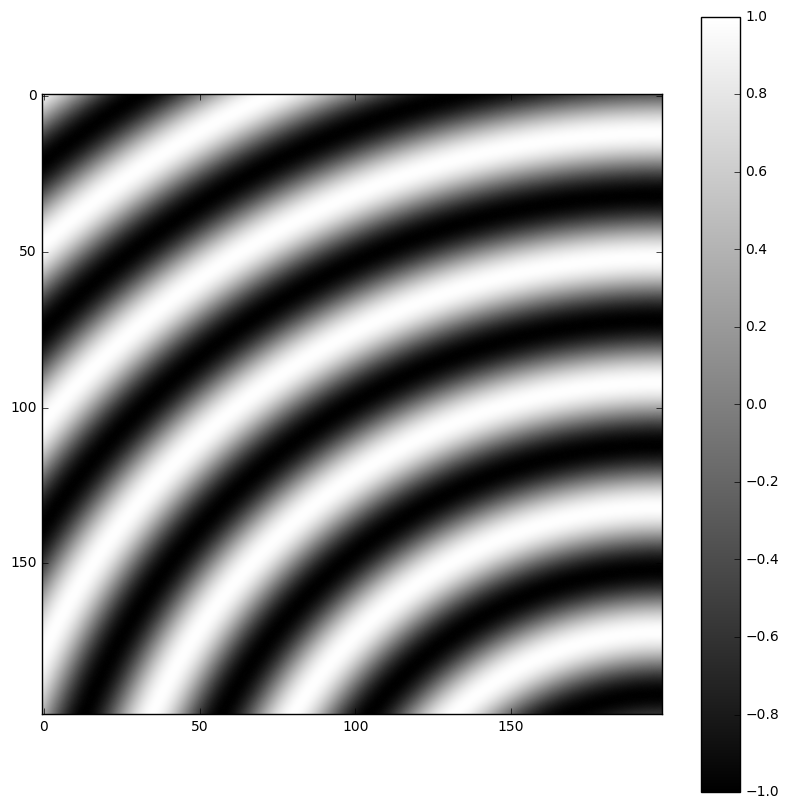

In [103]:
gkm = myGaborKernelCurve(frequency=5/200, sigma_x = 20, sigma_y = 20, theta=np.pi + np.pi/6, size = 200, psi=np.pi, r0 = 1*200)
plt.figure(figsize = (10,10))        # doctest: +SKIP
plt.imshow(gkm.real, interpolation='bicubic', cmap = 'gray')
plt.colorbar()# doctest: +SKIP
plt.show()

## Рисунок 1: Криволинейный Габор с делением на size. Рис.2 Криволинейный Габор без деления на size. Аналогично и тут. Freq следует уменишить в size-раз, а r0 увеличить в size-раз для получения аналогичного результата (переход от 1 к 2). ==> Изменение масштаба не критично. Но следует аккуратно обращаться с параметрами.

100.0 100.0


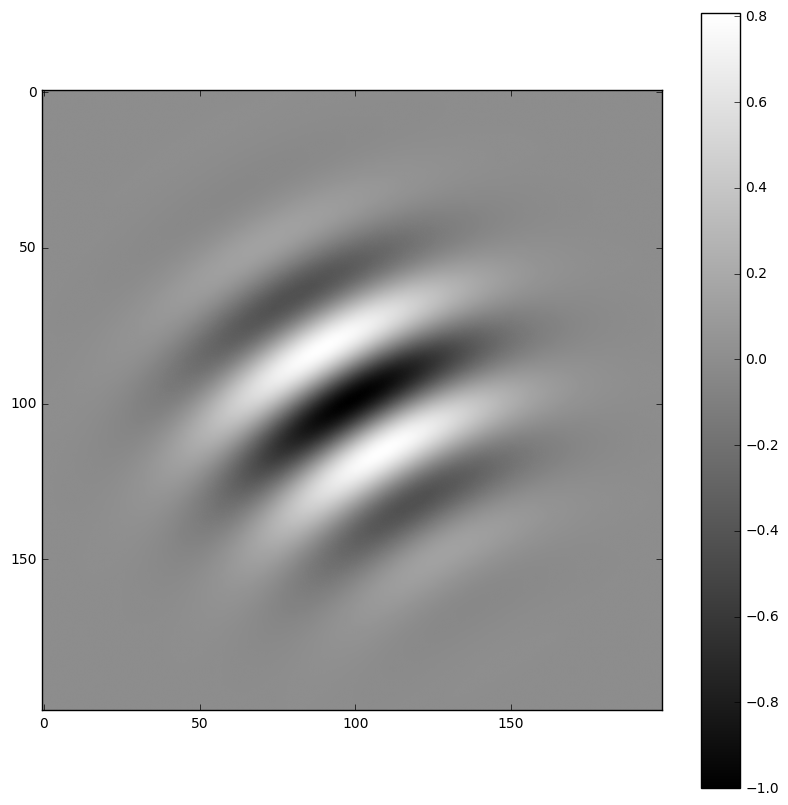

In [113]:
gkm = myGaborKernelCurve(frequency=5/200, sigma_x = 30, sigma_y = 30, theta=np.pi + np.pi/6, size = 200, psi=np.pi, r0 = 1*200)
plt.figure(figsize = (10,10))        # doctest: +SKIP
plt.imshow(gkm.real, interpolation='bicubic', cmap = 'gray')
plt.colorbar()# doctest: +SKIP
plt.show()

8.0 8.0


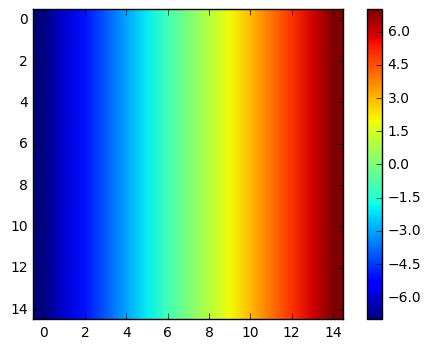

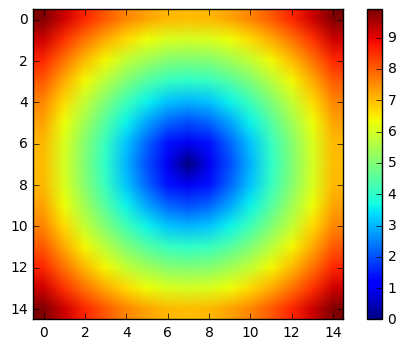

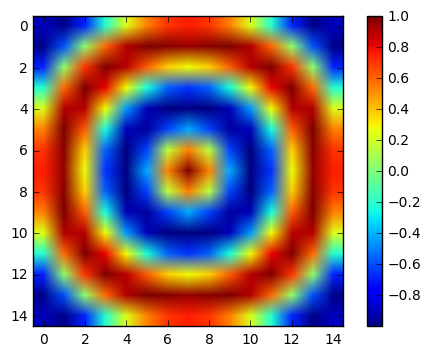

In [136]:
size = 15
r0 = 0
theta =  np.pi
cx = 0
cy = 0
x0 = np.ceil(max(size/2, 1))
y0 = np.ceil(max(size/2, 1))
print(x0,y0)
y, x = np.mgrid[-y0+1:y0, -x0+1:x0]
curvex = cx - r0*np.cos(theta)
curvey = cy - r0*np.sin(theta)

plt.imshow(x)
plt.colorbar()
plt.show()
r = np.sqrt((x - curvex)**2 + (y - curvey)**2)
plt.imshow(r)
plt.colorbar()
plt.show()
plt.imshow(np.cos(r))
plt.colorbar()
plt.show()

# Torch implementation

In [ ]:
import torch.nn as nn
import torch
from torch.autograd import Variable

In [ ]:
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair

class MyGabor(_ConvNd):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        
        super(MyGabor, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation,False, _pair(0), groups, bias)
        
        # TODO: подумать над инициализацией параметров
        
        self.device = "cpu"# torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        x0 = torch.ceil(torch.Tensor([self.kernel_size[0]/2]))[0]
        y0 = torch.ceil(torch.Tensor([self.kernel_size[1]/2]))[0]
        self.y, self.x = torch.meshgrid([torch.arange(-y0+1,y0), torch.arange(-x0+1,x0)])
        self.y, self.x = self.y.to(self.device), self.x.to(self.device)
        
        self.sigma_x = nn.Parameter((self.kernel_size[0]/5)*torch.rand(in_channels*out_channels))
        self.sigma_y = nn.Parameter((self.kernel_size[0]/5)*torch.rand(in_channels*out_channels))
        self.freq = nn.Parameter(self.kernel_size[0]*torch.rand(in_channels*out_channels))
        self.theta = nn.Parameter(6.28*torch.rand(in_channels*out_channels))
        self.psi = nn.Parameter(6.28*torch.rand(in_channels*out_channels))
        #self.evaluate = False
    
    #def eval(self):
        #self.evaluate = True
        
    #def train(self):
        #self.evaluate = False
        
    def forward(self, input):
        
        '''if self.evaluate == True:
            return F.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)'''
        
        #y, x = self.y.to(self.device), self.x.to(self.device)
        for i in range(self.in_channels):
            for j in range(self.out_channels):
                
                weight = torch.empty(self.weight.shape, requires_grad=False, device=self.device)
                g = torch.empty(self.y.shape, device=self.device)
                
                sigma_x = self.sigma_x[i*j].expand_as(self.y)
                sigma_y = self.sigma_y[i*j].expand_as(self.y)
                freq = self.freq[i*j].expand_as(self.y)
                theta = self.theta[i*j].expand_as(self.y)
                psi = self.psi[i*j].expand_as(self.y)
                
                rotx = self.x * torch.cos(theta) + self.y * torch.sin(theta)
                roty = -self.x * torch.sin(theta) + self.y * torch.cos(theta) 
                
                g = torch.exp(-0.5 * (rotx ** 2 / (sigma_x + 1e-3) ** 2 + roty ** 2 / (sigma_y + 1e-3) ** 2)) * torch.cos(2 * 3.14 * freq * rotx + psi)
                weight[j,i] = g
        self.weight.data = weight
        return F.conv2d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [ ]:
import torch.nn as nn
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair


class MyGabor(_ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)

        super(MyGabor, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, False, _pair(0), groups, bias)

        self.sigma_x = nn.Parameter(torch.rand(in_channels*out_channels))
        self.sigma_y = nn.Parameter(torch.rand(in_channels*out_channels))
        self.freq = nn.Parameter(torch.rand(in_channels*out_channels))
        self.theta = nn.Parameter(torch.rand(in_channels*out_channels))
        self.psi = nn.Parameter(torch.rand(in_channels*out_channels))
        #self.evaluate = False

    # def eval(self):
        #self.evaluate = True

    # def train(self):
        #self.evaluate = False

    def forward(self, input):
        '''if self.evaluate == True:
            return F.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)'''

        x0 = torch.ceil(torch.Tensor([self.kernel_size[0]/2]))[0]
        y0 = torch.ceil(torch.Tensor([self.kernel_size[1]/2]))[0]

        weight = torch.empty(self.weight.shape, requires_grad=False)
        for i in range(self.in_channels):
            for j in range(self.out_channels):
                y, x = torch.meshgrid([torch.arange(-y0+1, y0), torch.arange(-x0+1, x0)])

                sigma_x = self.sigma_x[i*j].expand_as(y)
                sigma_y = self.sigma_y[i*j].expand_as(y)
                freq = self.freq[i*j].expand_as(y)
                theta = self.theta[i*j].expand_as(y)
                psi = self.psi[i*j].expand_as(y)

                rotx = x * torch.cos(theta) + y * torch.sin(theta)
                roty = -x * torch.sin(theta) + y * torch.cos(theta)
                g = torch.zeros(y.shape)
                g = torch.exp(-0.5 * (rotx ** 2 / (sigma_x + 1e-3) ** 2 + roty ** 2 / (sigma_y + 1e-3) ** 2))
                g = g * torch.cos(2 * 3.14 * freq * rotx + psi)
                weight[j, i] = g
        self.weight = nn.Parameter(weight)
        return F.conv2d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


## GNet sample

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_set = dset.MNIST(root='', train=True, download=True, transform=transform)
test_set = dset.MNIST(root='', train=False, download=True, transform=transform)

batch_size = 64

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        self.g1 = MyGabor(1, 3, kernel_size=(7,7))
        self.p1 = nn.MaxPool2d(23, stride=1)
        self.g2 = MyGabor(3, 5, kernel_size=(7,7))
        self.p2 = nn.MaxPool2d(23, stride=1)
        self.g3 = MyGabor(5, 7, kernel_size=(7,7))
        self.p3 = nn.MaxPool2d(23, stride=1)
        
        self.fc4 = nn.Linear(16*16*7, 10)

    def forward(self, x):
        x = self.p1(F.relu(self.g1(x)))
        x = self.p2(F.relu(self.g2(x)))
        x = self.p3(F.relu(self.g3(x)))
        
        x = x.view(-1, 16*16*7)
        x = F.softmax(self.fc4(x))
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = Net()
net = net.to(device)

In [ ]:
from time import time
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to, labels
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).to('cpu')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 20))
            print(net.fc4.weight.grad)
            running_loss = 0.0
            
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = net(data).to('cpu')
            test_loss += criterion(output, target) # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

print('Finished Training')

In [ ]:
net.g1.theta.grad

### Очень странные результаты: точность больше 50% после первых 20 батчей.
TODO: проверить на ошибки

## ConvNet comparison

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from time import time

transform = transforms.Compose([transforms.ToTensor()])

train_set = dset.MNIST(root='', train=True, download=True, transform=transform)
test_set = dset.MNIST(root='', train=False, download=True, transform=transform)

batch_size = 4096

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.c0 = nn.Conv2d(1, 32, kernel_size=(3,3))
        self.c1 = nn.Conv2d(32, 64, kernel_size=(3,3))
        
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x
        x = F.relu(self.c0(x))
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = nn.Dropout2d(p = 0.25)(x)
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(x))
        x = nn.Dropout()(x)
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
convnet = ConvNet()
convnet = convnet.to(device)

In [ ]:
convnet(torch.rand(1,1,28,28,device=device))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnet.parameters())
start = time()
for epoch in range(12):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = convnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        '''running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0'''
            
    #convnet.eval()
    '''test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = convnet(data).to('cpu')
            test_loss += criterion(output, target) # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100 * correct / len(test_loader.dataset)))'''
print(time() - start)
print('Finished Training')

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from time import time

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
start = time()
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(time() - start)